In [1]:
import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display, clear_output
from IPython import display as ipd

In [2]:
def readMeetingAudio(audioPath):
    meetingAudio_fs, meetingAudio = wavfile.read(audioPath)
    if not ((meetingAudio[:, 0] == meetingAudio[:, 1]).any() == False):
        meetingAudio = meetingAudio[:, 1]
    return meetingAudio_fs, meetingAudio

In [3]:
def rolling_window(a, size):
    shape = a.shape[:-1] + (a.shape[-1] - size + 1, size)
    strides = a.strides + (a. strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [4]:
beepAudio_sr, beepAudio = wavfile.read('beep-01a.wav')

In [5]:
meetingAudioFiles = ['z.wav', 'zoom2.wav', 'P1.wav', 'P2.wav']
meetings = [readMeetingAudio(f) for f in meetingAudioFiles]

In [17]:
meeting_sr, meeting = meetings[3]

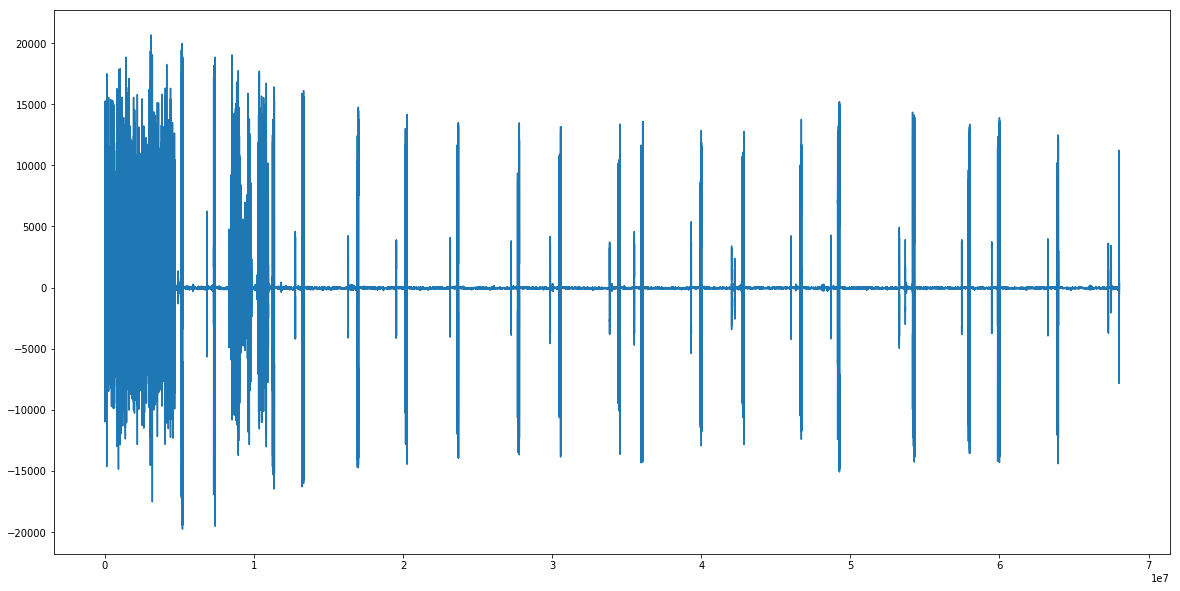

In [18]:
fig =plt.figure(figsize=(20,10))
plt.plot(meeting)

In [19]:
def getNoiseIntervals(audio, fs, threshold = 3000):
    audio = abs(audio)
    loudIndices = np.where(audio > threshold)[0]
    loudStartIndex = loudIndices[0]
    lastLoudIndex = loudIndices[0]
    noiseIntervals = []
    for i in range(len(loudIndices[1:-1])):
        if lastLoudIndex + fs >= loudIndices[i]:
            if loudIndices[i] + fs < loudIndices[i+1]:
                noiseIntervals.append((loudStartIndex, loudIndices[i]))
        else:
            loudStartIndex = loudIndices[i]
        lastLoudIndex = loudIndices[i]
    if len(loudIndices) > 0:
        if len(noiseIntervals) == 0: 
            noiseIntervals.append((loudStartIndex, loudIndices[-1]))
        elif noiseIntervals[-1] != (loudStartIndex, loudIndices[i]):
            noiseIntervals.append((loudStartIndex, loudIndices[i]))
    return noiseIntervals

In [20]:
noiseIntervals = getNoiseIntervals(meeting, meeting_sr/25, threshold = 2000)
print(len(noiseIntervals))

465


In [21]:
loudIndices = np.zeros_like(meeting)
for i, j in noiseIntervals:
    loudIndices[i] = 3000
    loudIndices[j] = 3000

In [30]:
t = lambda s: '%02d:%02d' % (int(s/60), int(s % 60))
it = lambda m, s: int((m*60+s)*meeting_sr)

In [23]:
def findTrueCorrelation(audio, fltr, distance = 50):
    corrs = []
    if len(audio) <= distance or len(audio) <= len(fltr)/5:
        return 0
    elif len(audio) > len(fltr):
        windows = rolling_window(audio, len(fltr))
        windows = [windows[i] for i in range(0, len(windows), int(len(windows)/10))]
        corrs = [np.corrcoef(row, fltr)[0, 1] for row in windows]
    else:
        for i in range(distance):
            corrs.append(np.corrcoef(audio[i:], fltr[:len(audio)-i])[0, 1])
    if not corrs: return 0
    return max(corrs)

In [31]:
beepIntervals = []
for beginIndex, endIndex in noiseIntervals:
    corrs = findTrueCorrelation(meeting[beginIndex:endIndex], beepAudio, distance = 50)
    if corrs > 0.3:
        print('%s - %.2f, %.2f'%(t(beginIndex/meeting_sr), (endIndex-beginIndex)/meeting_sr, corrs))
        beepIntervals.append((beginIndex, endIndex))
#     else:
#         print('%s - %.2f'%(t(beginIndex/meeting_sr), (endIndex-beginIndex)/meeting_sr))

01:57 - 1.11, 0.31
02:35 - 0.23, 0.94
02:47 - 0.61, 0.89
03:08 - 0.26, 0.92
04:17 - 0.55, 0.91
04:49 - 0.21, 0.94
05:02 - 0.54, 0.90
06:10 - 0.22, 0.94
06:25 - 0.55, 0.92
07:23 - 0.22, 0.93
07:39 - 0.57, 0.93
08:45 - 0.23, 0.93
08:57 - 0.55, 0.92
10:17 - 0.21, 0.92
10:29 - 0.53, 0.92
11:17 - 0.23, 0.93
11:33 - 0.49, 0.91
12:47 - 0.23, 0.93
13:02 - 0.60, 0.92
13:25 - 0.27, 0.93
13:37 - 0.52, 0.92
14:51 - 0.23, 0.92
15:07 - 0.53, 0.92
15:53 - 0.22, 0.93
16:11 - 0.56, 0.91
17:23 - 0.23, 0.93
17:39 - 0.54, 0.92
18:24 - 0.22, 0.93
18:36 - 0.53, 0.90
20:08 - 0.22, 0.92
20:30 - 0.55, 0.90
21:43 - 0.21, 0.91
21:54 - 0.56, 0.90
22:28 - 0.22, 0.93
22:40 - 0.48, 0.89
23:54 - 0.23, 0.92
24:09 - 0.52, 0.90
25:26 - 0.22, 0.92


In [25]:
len(beepIntervals)

38

In [26]:
beepIndices = np.zeros_like(meeting)
for i, j in beepIntervals:
    beepIndices[i] = 3000
    beepIndices[j] = 3000 

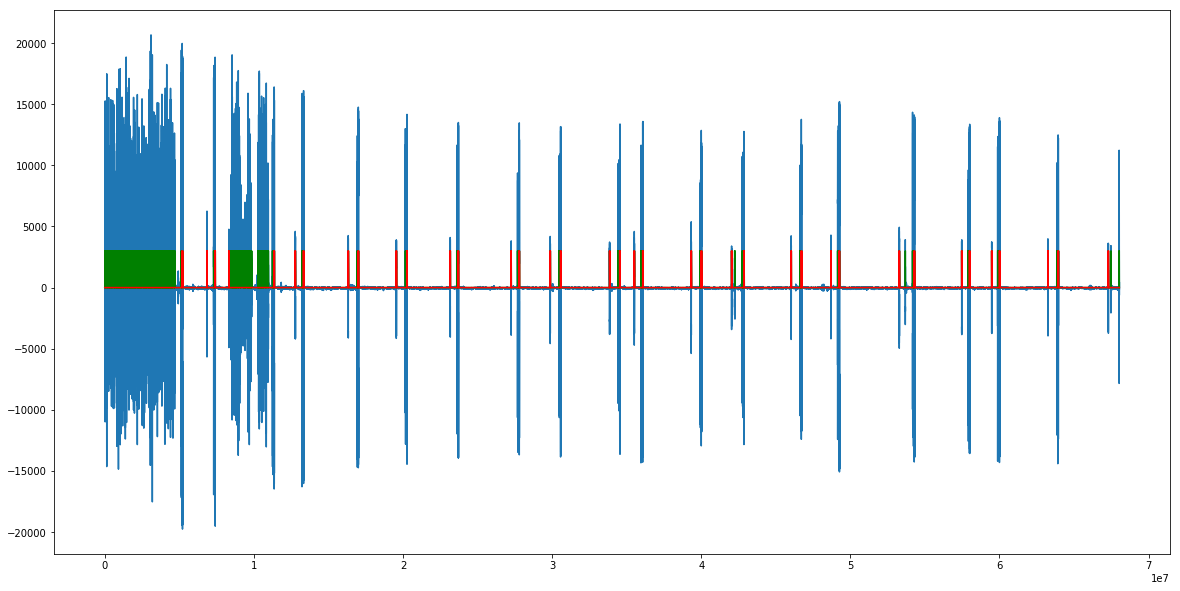

In [27]:
fig = plt.figure(figsize=(20,10))
plt.plot(meeting)
plt.plot(loudIndices, color='green')
plt.plot(beepIndices, color='red')

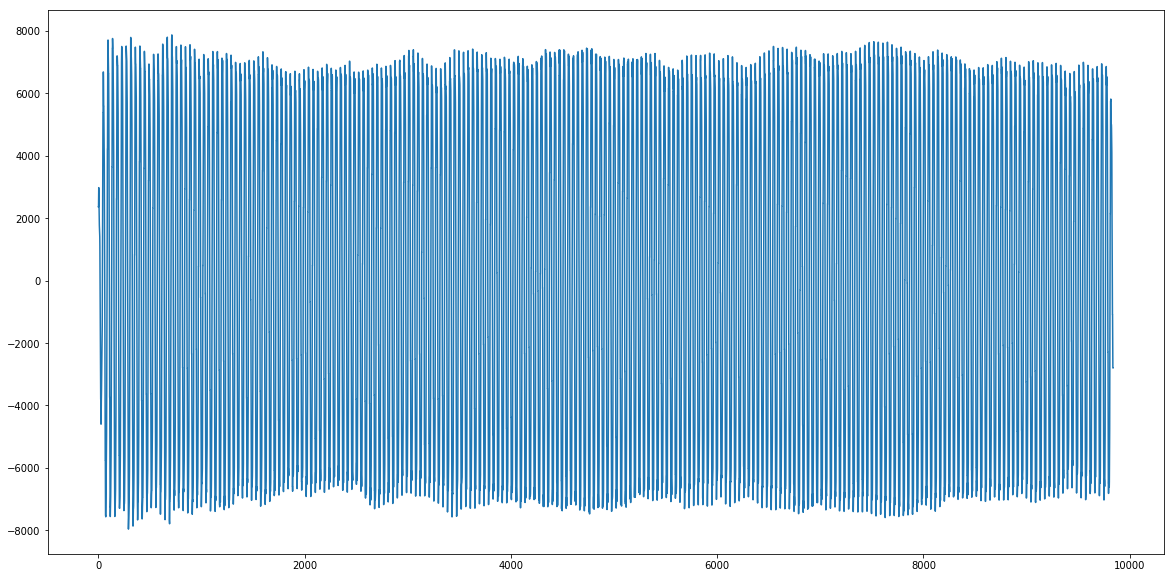

In [123]:
fig =plt.figure(figsize=(20,10))
beginIndex, endIndex = noiseIntervals[-1]
plt.plot(meeting[beginIndex:endIndex])

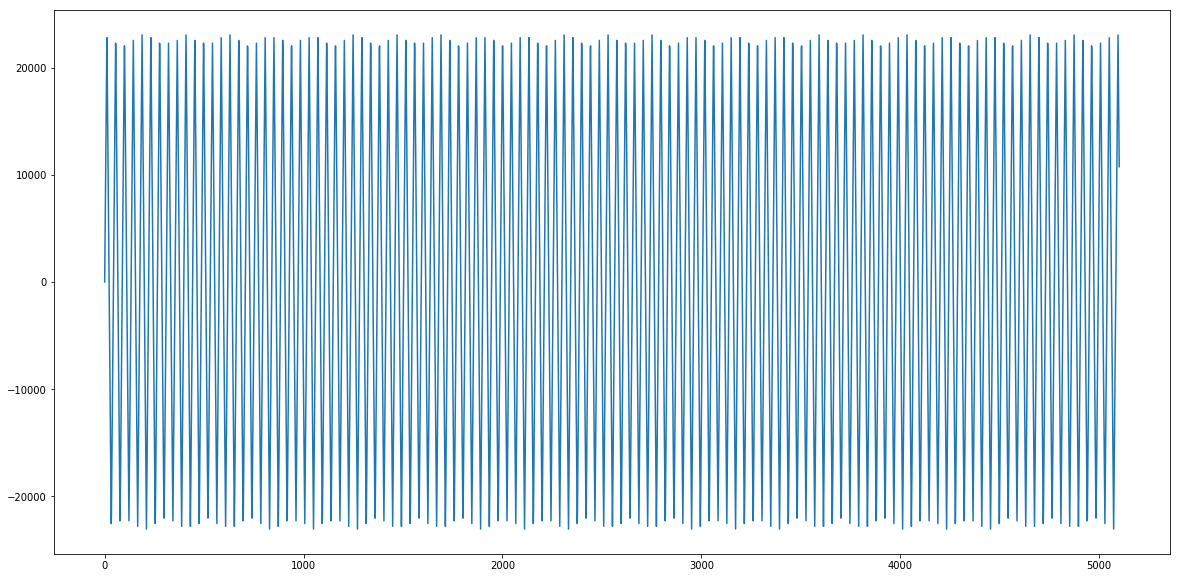

In [81]:
fig =plt.figure(figsize=(20,10))
plt.plot(beepAudio[:endIndex-beginIndex])